In [5]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import numpy as np
import cv2
from PIL import Image
import pytesseract
from google.colab.patches import cv2_imshow
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
from collections import defaultdict

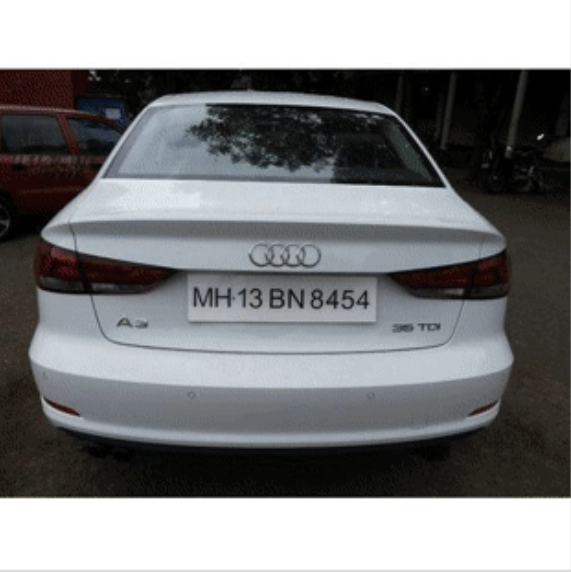

In [7]:
img = cv2.imread("/content/drive/MyDrive/CVpackage/images/sample.png")
cv2_imshow(img)

Gaussian Blur: Here we use a Gaussian kernel to smoothen the image. 

This technique is highly effective to remove Gaussian noise. 


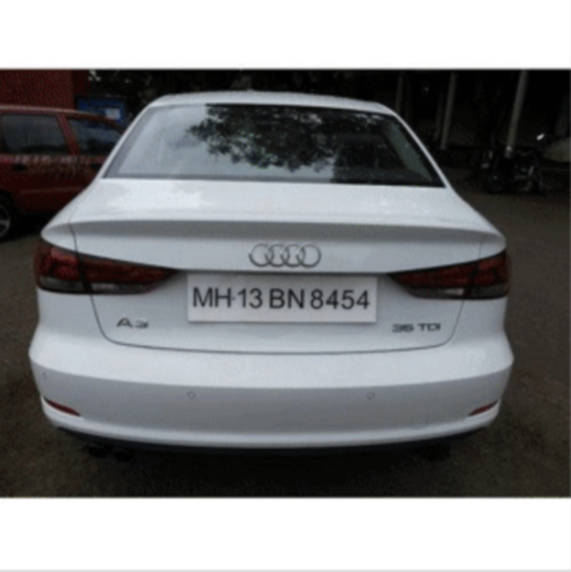

In [8]:
# Gaussian Blur
img2 = cv2.GaussianBlur(img, (3,3), 0)
cv2_imshow(img2)

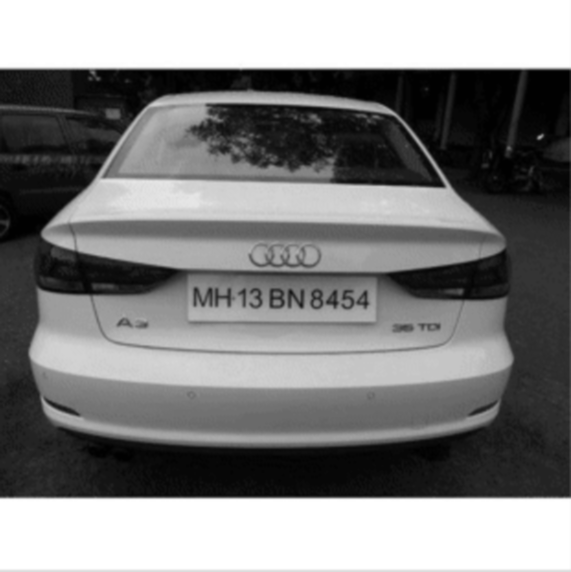

In [9]:
# Convert to B/W
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
cv2_imshow(img2)

Sobel: Here we calculate the derivatives from the image. 

Using derivatives we calculate the gradients, and a high change in gradient indicates a major change in the image. 

OpenCV provides a cv2.Sobel() function to calculate Sobel operators.

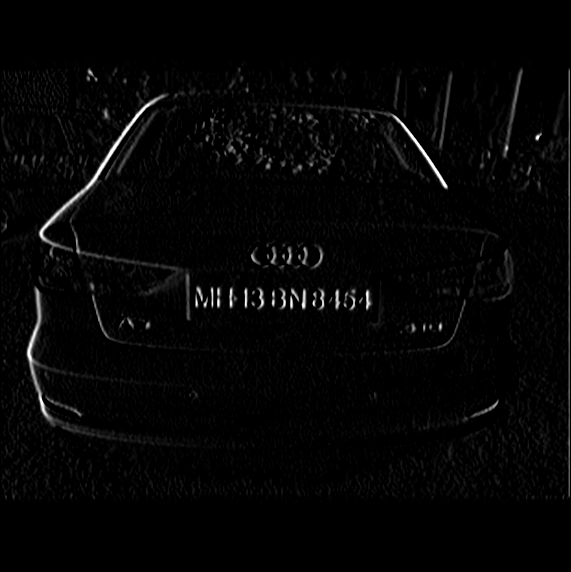

In [10]:
# Sobel
img2 = cv2.Sobel(img2,cv2.CV_8U,1,0,ksize=3)
cv2_imshow(img2)

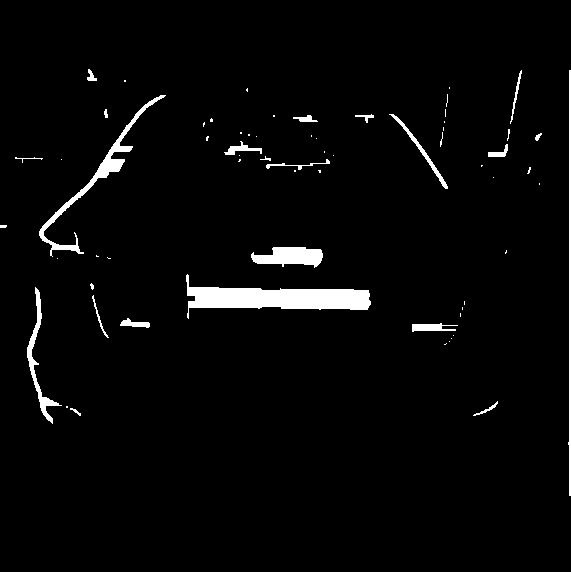

In [11]:
# morphological operation Close: Dilation followed by Erosion
_,img2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
morph_img_threshold = img2.copy()
cv2.morphologyEx(src=img2, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)
Image.fromarray(morph_img_threshold)

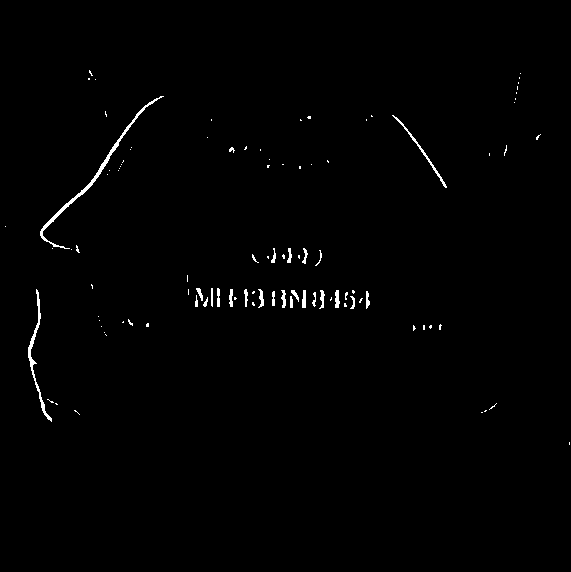

In [12]:
# contours
num_contours, hierarchy= cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
contour_img = cv2.drawContours(img2, num_contours, -1, (0,255,0), 1)
Image.fromarray(contour_img)

In [ ]:
def ratioCheck(area, width, height):
    ratio = float(width) / float(height)
    if ratio < 1:
        ratio = 1 / ratio
    if (area < 6000 or area > 70000) or (ratio < 3 or ratio > 6):
        return False
    return True

def isMaxWhite(plate):
    avg = np.mean(plate)
    if(avg>=115):
        return True
    else:
         return False

def ratio_and_rotation(rect):
    (x, y), (width, height), rect_angle = rect

    if(rect_angle > 60):
        width, height = height, width

    if height == 0 or width == 0:
        return False
    if height > width:
        return False

    area = height*width
    if not ratioCheck(area,width,height):
        return False
    else:
        return True

for i, cnt in enumerate(num_contours):
    min_rect = cv2.minAreaRect(cnt)
    if ratio_and_rotation(min_rect):
        x,y,w,h = cv2.boundingRect(cnt)
        plate_img = img[y:y+h,x:x+w]
        cv2_imshow(plate_img)
        if(isMaxWhite(plate_img)):
          plate_im = Image.fromarray(plate_img)
          text = pytesseract.image_to_string(plate_im, lang='eng')
          print("Number Detected Plate Text : ",text)

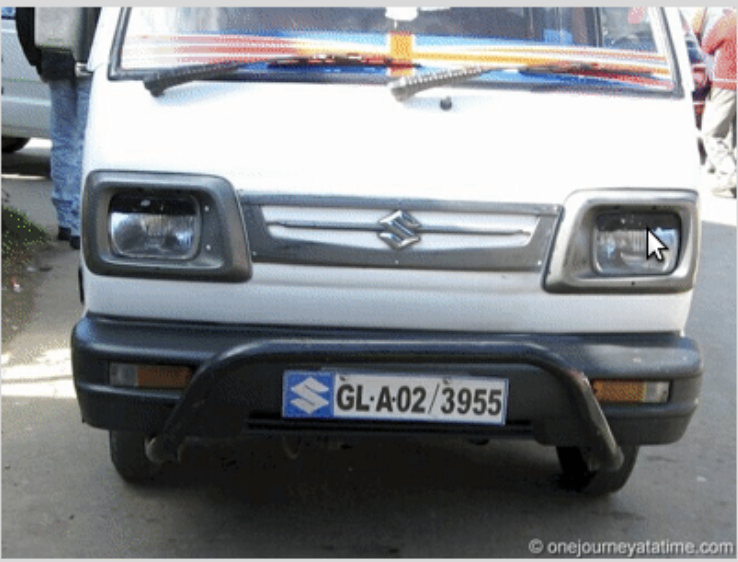

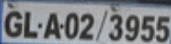

Number Detected Plate Text :  GL-A02/3955



In [14]:
def detect(img):
  # Gaussian Blur
  img2 = cv2.GaussianBlur(img, (3,3), 0)

  # Convert to B/W
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

  # Sobel
  img2 = cv2.Sobel(img2,cv2.CV_8U,1,0,ksize=3)

  # morphological operations Close: Dilation followed by Erosion
  _,img2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
  morph_img_threshold = img2.copy()
  cv2.morphologyEx(src=img2, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)

  # contours
  num_contours, hierarchy= cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
  contour_img = cv2.drawContours(img2, num_contours, -1, (0,255,0), 1)

  for i, cnt in enumerate(num_contours):
      min_rect = cv2.minAreaRect(cnt)
      if ratio_and_rotation(min_rect):
          x,y,w,h = cv2.boundingRect(cnt)
          plate_img = img[y:y+h,x:x+w]
          cv2_imshow(plate_img)
          if(isMaxWhite(plate_img)):
            plate_im = Image.fromarray(plate_img)
            text = pytesseract.image_to_string(plate_im, lang='eng')
            print("Number Detected Plate Text : ",text)

img = cv2.imread("/content/drive/MyDrive/CVpackage/images/sample1.png")
cv2_imshow(img)
detect(img)

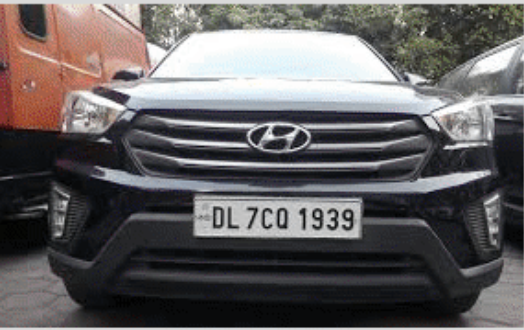

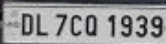

Number Detected Plate Text :  DL 7CO 1939



In [15]:
img = cv2.imread("/content/drive/MyDrive/CVpackage/images/sample2.png")
cv2_imshow(img)
detect(img)

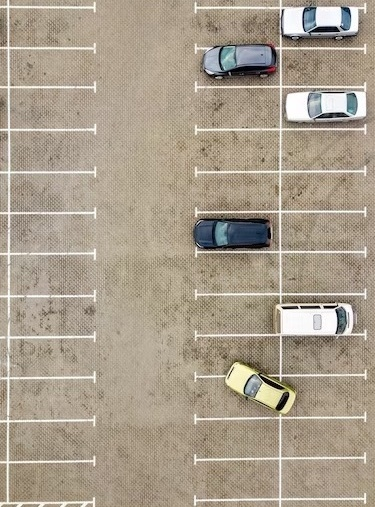

In [16]:
img = cv2.imread('/content/drive/MyDrive/CVpackage/images/empty_lot_3.jpeg')
cv2_imshow(img)

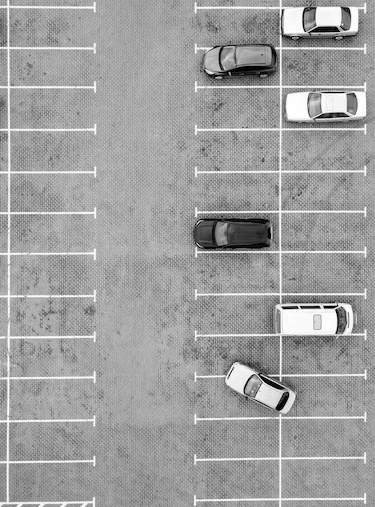

In [17]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

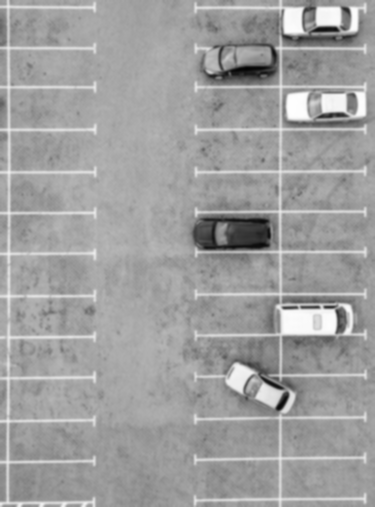

In [18]:
blur_gray = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
cv2_imshow(blur_gray)

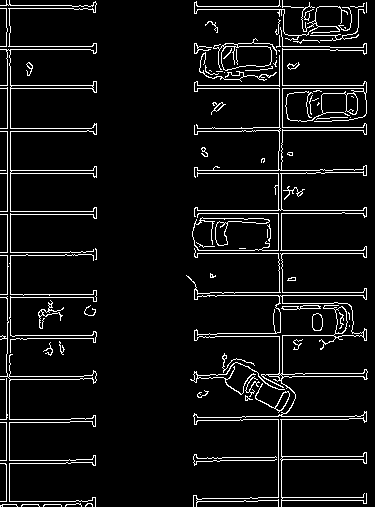

In [19]:
edges = cv2.Canny(blur_gray, 50, 150)
cv2_imshow(edges)

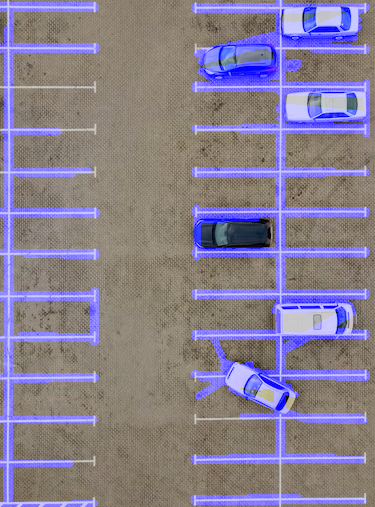

In [20]:
rho = 1
theta = np.pi / 180
threshold = 15
min_line_length = 50
max_line_gap = 20
line_image = np.copy(img) * 0

lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 5)

lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)
cv2_imshow(lines_edges)

Num Parking Lanes:  2


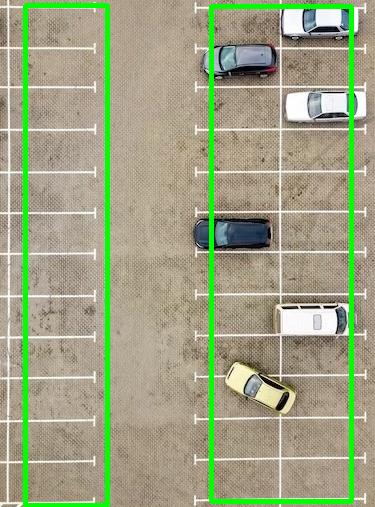

In [21]:
def identify_blocks(image, lines):
    new_image = np.copy(image)
    # Create a clean list of lines
    cleaned = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            cleaned.append((x1,y1,x2,y2))
    
    # Sort cleaned by x1 position
    import operator
    list1 = sorted(cleaned, key=operator.itemgetter(0, 1))
    
    # Find clusters of x1 close together - clust_dist apart
    clusters = {}
    dIndex = 0
    clus_dist = 20

    for i in range(len(list1) - 1):
        distance = abs(list1[i+1][0] - list1[i][0])
        if distance <= clus_dist:
            if not dIndex in clusters.keys(): clusters[dIndex] = []
            clusters[dIndex].append(list1[i])
            clusters[dIndex].append(list1[i + 1])
        else:
            dIndex += 1

    # Identify coordinates of rectangle around this cluster
    rects = {}
    i = 0
    for key in clusters:
        all_list = clusters[key]
        cleaned = list(set(all_list))
        if len(cleaned) > 5:
            cleaned = sorted(cleaned, key=lambda tup: tup[1])
            avg_y1 = cleaned[0][1]
            avg_y2 = cleaned[-1][1]
            #print(avg_y1, avg_y2)
            avg_x1 = 0
            avg_x2 = 0
            for tup in cleaned:
                avg_x1 += tup[0]
                avg_x2 += tup[2]
            avg_x1 = avg_x1/len(cleaned)
            avg_x2 = avg_x2/len(cleaned)
            rects[i] = (avg_x1, avg_y1, avg_x2, avg_y2)
            i += 1
    
    print("Num Parking Lanes: ", len(rects))
    # Draw the rectangles on the image
    buff = 30
    for key in rects:
        tup_topLeft = (int(abs(rects[key][0] - buff)), int(abs(rects[key][1])))
        tup_botRight = (int(abs(rects[key][2] + buff)), int(abs(rects[key][3])))
        #print(tup_topLeft, tup_botRight)
        cv2.rectangle(new_image, tup_topLeft,tup_botRight,(0,255,0),3)
    return new_image, rects

new_image, rects = identify_blocks(img, lines)
    
cv2_imshow(new_image)

total parking spaces:  35


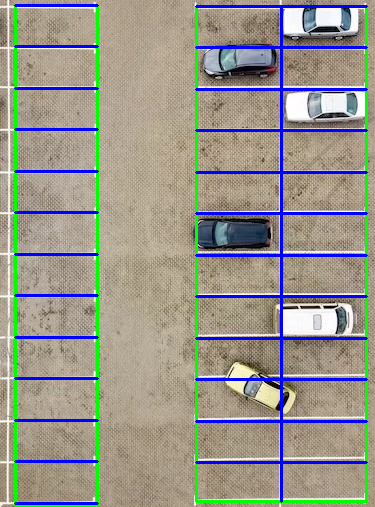

In [37]:
def draw_parking(image, rects, color=[255, 0, 0], thickness=2):
    new_image = np.copy(image)
    gap = 41.5
    spot_dict = {} # maps each parking ID to its coords
    tot_spots = 0

    for key in rects:
        # Horizontal lines
        tup = rects[key]
        buff = 20 if key == 0 else 45

        x1 = int(abs(tup[0] - buff))
        x2 = int(abs(tup[2] + buff))
        y1 = int(abs(tup[1]))
        y2 = int(abs(tup[3]))
        cv2.rectangle(new_image, (x1, y1),(x2,y2),(0,255,0),2)
        num_splits = int(abs(y2-y1)//gap)
        for i in range(0, num_splits+1):
            y = int(y1 + i*gap)
            cv2.line(new_image, (x1, y), (x2, y), color, thickness)
        if key == 1:    
          x = int((x1 + x2)/2)
          cv2.line(new_image, (x, y1), (x, y2), color, thickness)
        # Add up spots in this lane
        if key == 0:
            tot_spots += num_splits +1
        else:
            tot_spots += 2*(num_splits +1)

        # Dictionary of spot positions
        if key == 0:
            for i in range(0, num_splits+1):
                cur_len = len(spot_dict)
                y = int(y1 + i*gap)
                spot_dict[(x1, y, x2, y+gap)] = cur_len +1        
        else:
            for i in range(0, num_splits+1):
                cur_len = len(spot_dict)
                y = int(y1 + i*gap)
                x = int((x1 + x2)/2)
                spot_dict[(x1, y, x, y+gap)] = cur_len +1
                spot_dict[(x, y, x2, y+gap)] = cur_len +2   
    
    print("total parking spaces: ", cur_len)
    return new_image, spot_dict

new_image, spot_dict = draw_parking(img, rects)
cv2_imshow(new_image)

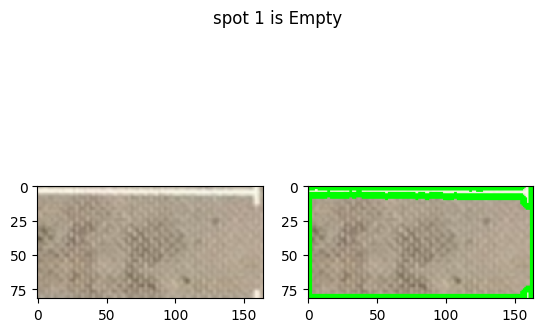

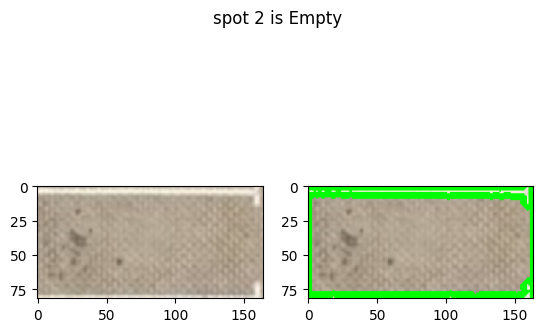

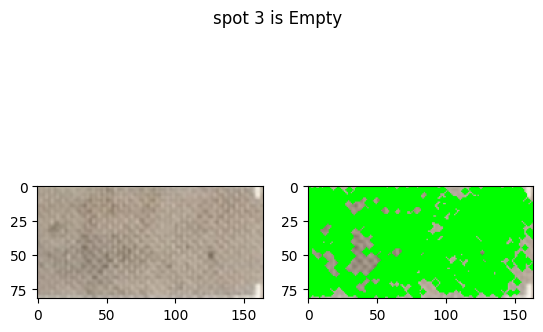

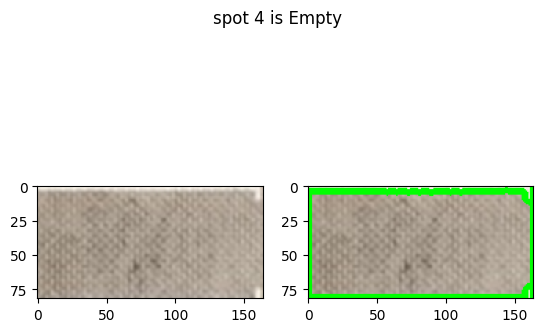

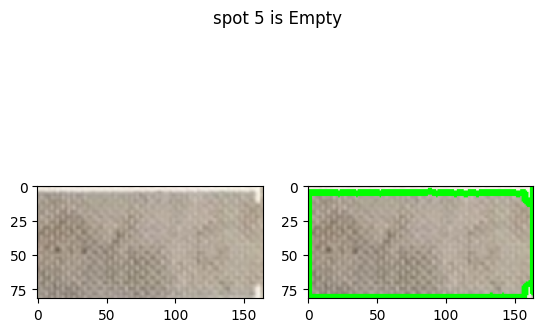

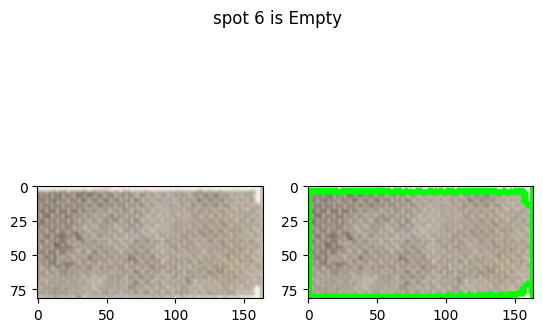

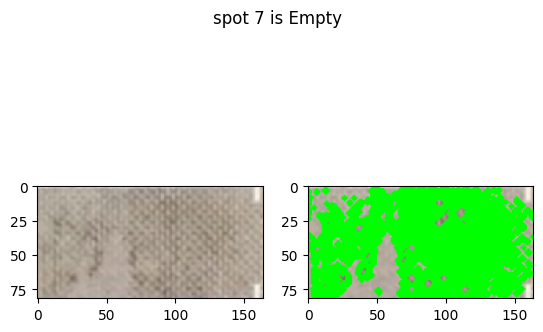

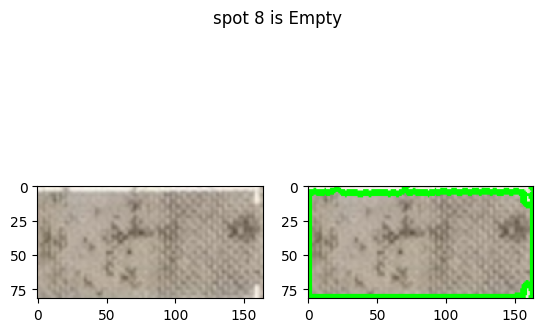

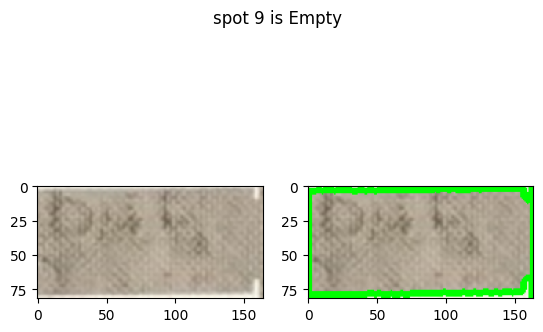

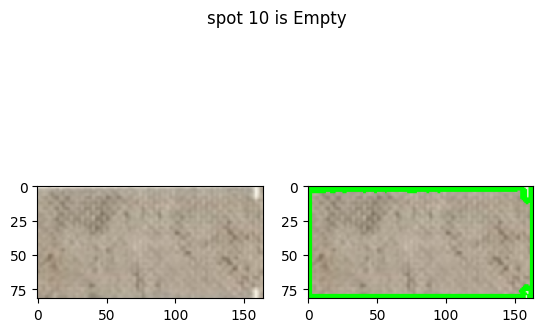

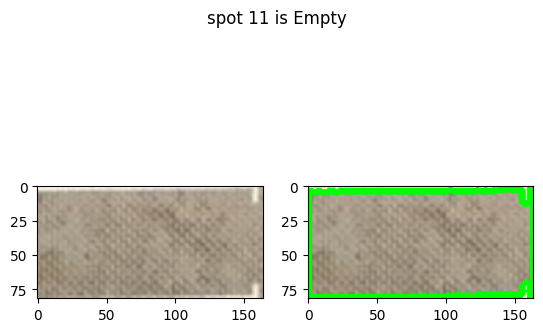

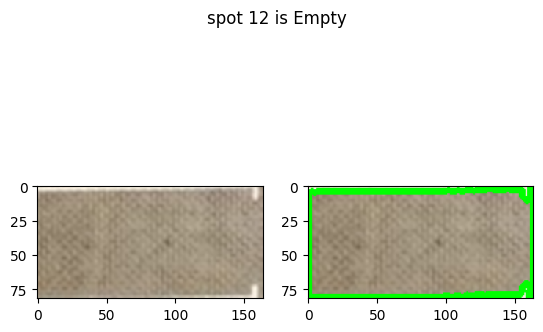

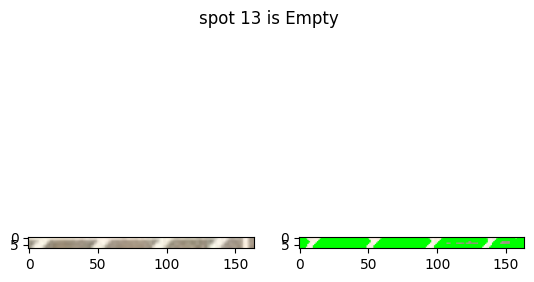

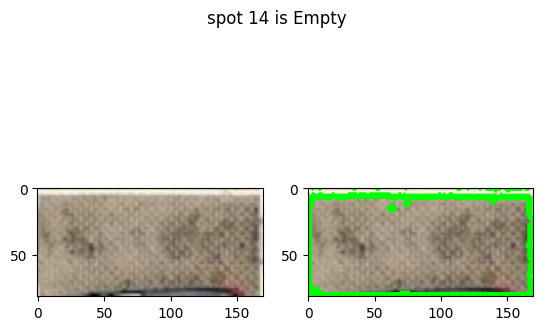

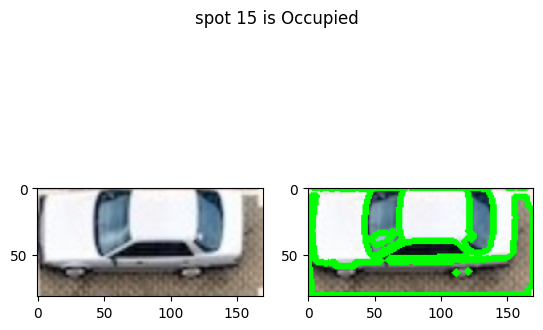

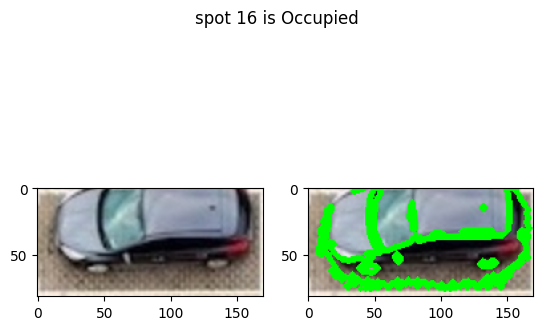

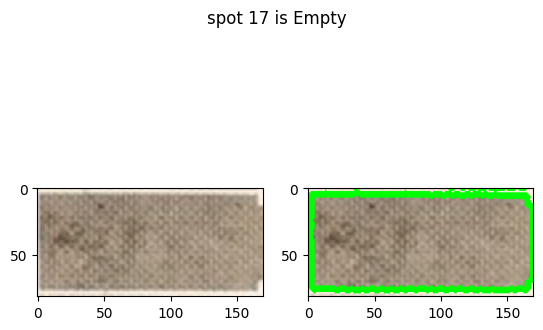

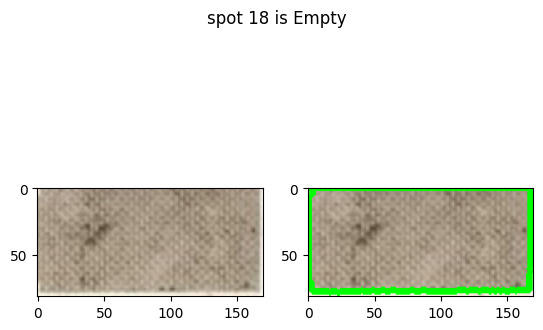

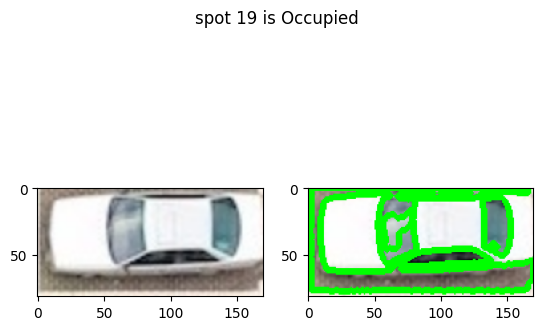

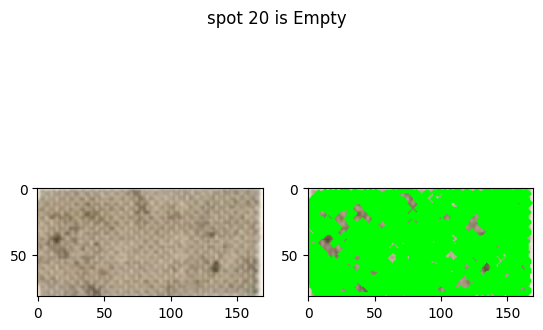

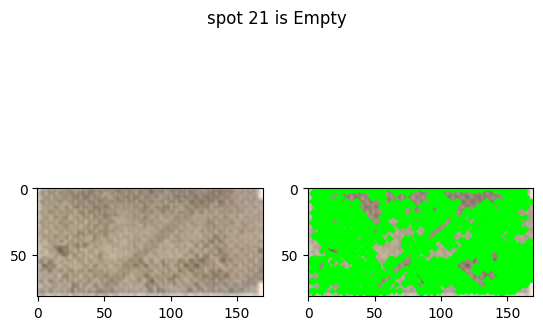

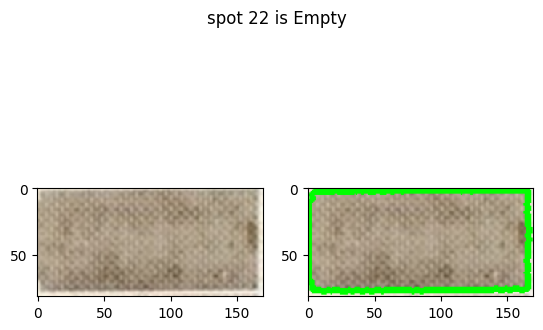

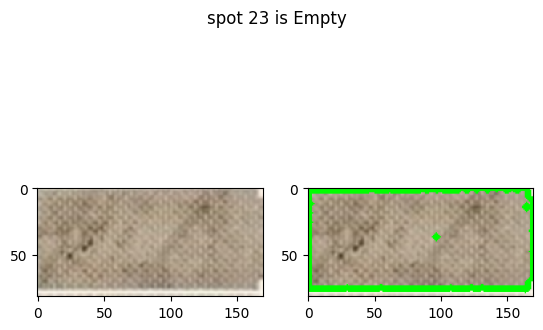

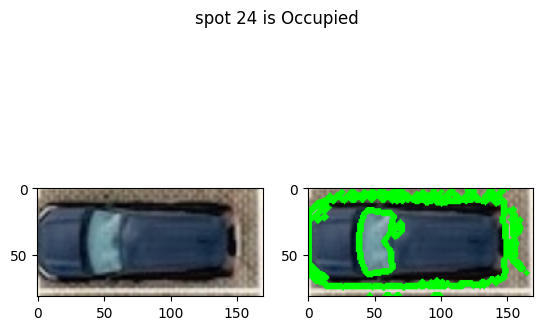

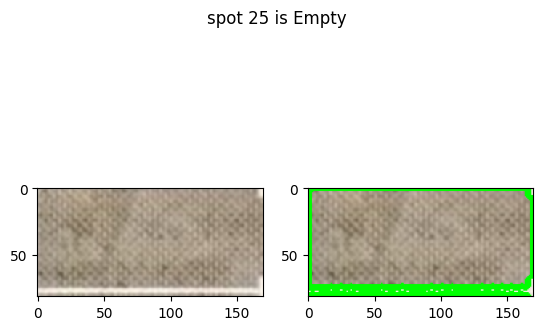

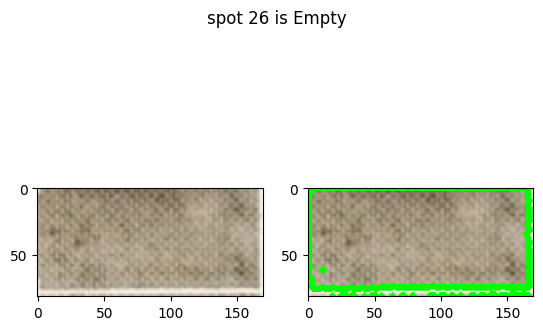

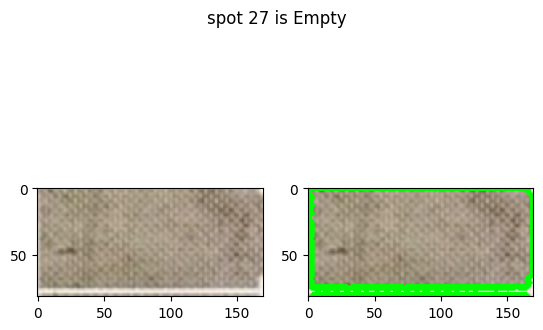

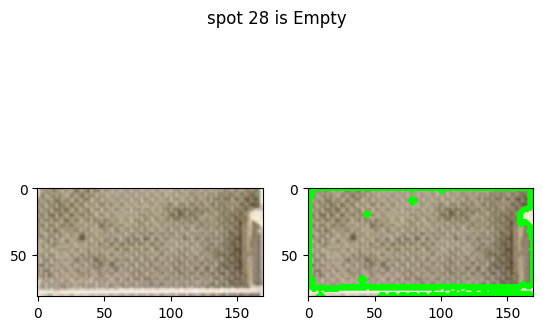

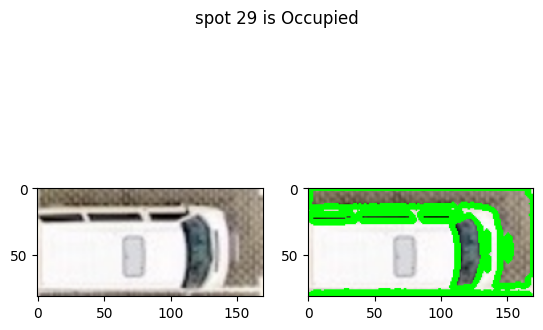

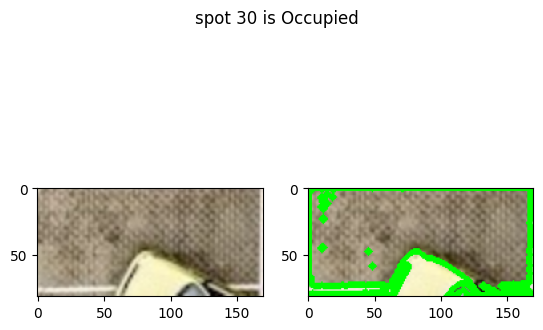

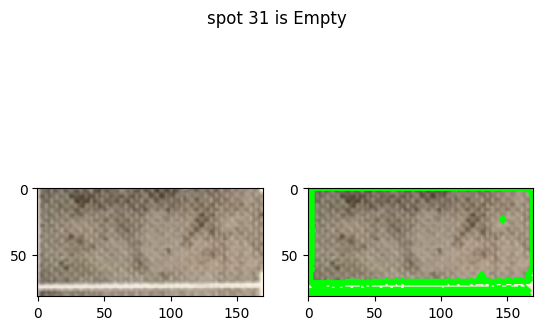

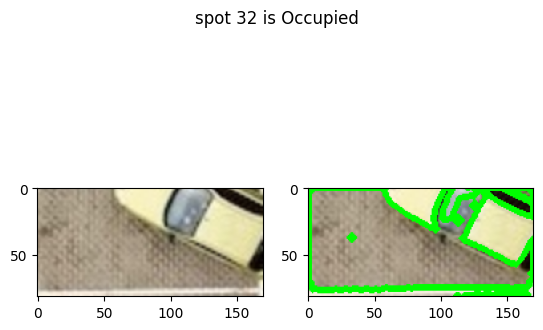

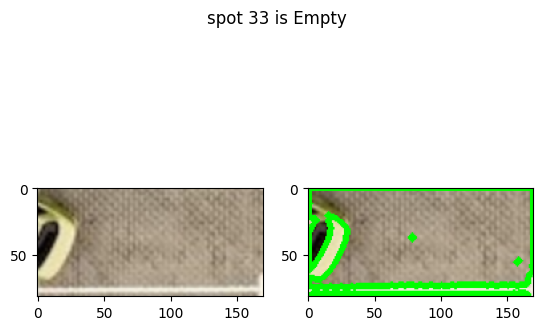

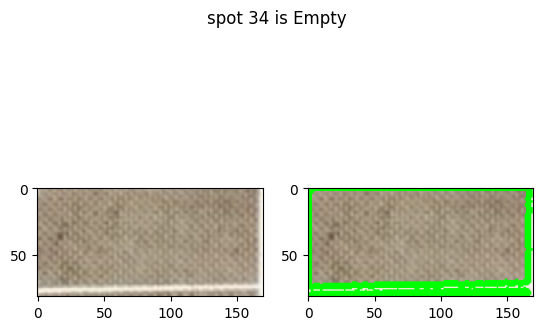

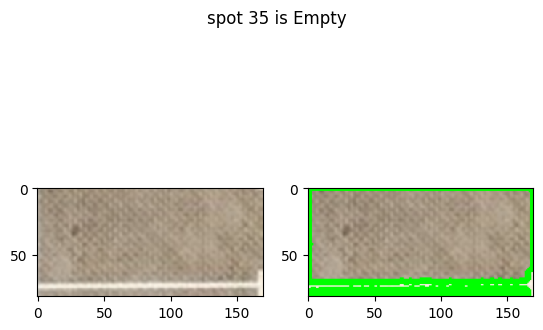

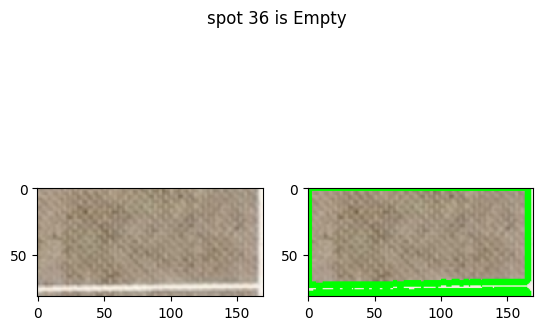

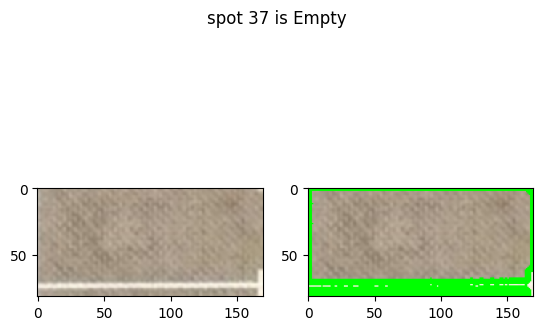

In [38]:
def detect_car(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  new_image = np.copy(img)
  
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(new_image, contours, -1, (0, 255, 0), 3)
  
  if len(contours) <= 50:
    for cnt in contours:
      area = cv2.contourArea(cnt)
      if area > 4000 and area < 11640:
        return "Occupied", img, new_image
  return "Empty", img, new_image

spots_available = defaultdict(lambda: [])

for spot in spot_dict.keys():
    (x1, y1, x2, y2) = spot
    (x1, y1, x2, y2) = (int(abs(x1)), int(abs(y1)), int(abs(x2)), int(abs(y2)))
    spot_img = img[y1:y2, x1:x2]
    spot_img = cv2.resize(spot_img, (0,0), fx=2.0, fy=2.0)
    spot_id = spot_dict[spot]
    title, image, new_image = detect_car(spot_img)
    spots_available[title].append(spot_id)
    plt.figure()
    plt.suptitle('spot ' + str(spot_id) + ' is ' + title)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(new_image)
    plt.show()

In [32]:
for spot in spots_available.keys():
  print(spot + ' slots:')
  print(spots_available[spot])

Empty slots:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 31, 33, 34, 35, 36, 37]
Occupied slots:
[15, 16, 19, 24, 29, 30, 32]
